# Import Library

In [387]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob 
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score , classification_report
import pandas_profiling
from category_encoders import OneHotEncoder
from sklearn.metrics import mean_squared_error  
from sklearn.model_selection import cross_validate

In [388]:
t=pd.read_csv("test.csv")
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


# Import Data 

In [389]:
def wrangel(path):
    # read data 
    df=pd.read_csv(path)
    #extract the social name
    df["title"]=df["Name"].str.extract("([A-Za-z]+)\.",expand=False)
    #convert title categorcal data 
    df.loc[df["title"]=="Mr"   , "title"]   = 0   
    df.loc[df["title"]=="Miss"   , "title"]   = 1
    df.loc[df["title"]=="Mrs"   , "title"]   = 2 
    df.loc[df["title"]=="Master"   , "title"]   = 3    
    conditions = (df["title"] == 'Ms') | (df["title"] == 'Col') | (df["title"] == 'Rev') | (df["title"] == 'Dr') | (df["title"] == 'Dona')
    df.loc[conditions, "title"] = 4
    #fill NAN Value of Fare Accorging to Social Name
    df["Fare"].fillna(df.groupby("Pclass")["Fare"].transform("median"),inplace=True)
    #fill NAN Value of Age Accorging to Social Name
    df["Age"].fillna(df.groupby("title")["Age"].transform("median"),inplace=True)
    #fill NAN Value of Embarked Accorging to Median
    df["Embarked"]=df["Embarked"].fillna("S")
    #remove nan columns
    drop=[]
    drop.append("Cabin")
    drop.append("Name")
    drop.append("Ticket")
    drop.append("title")
    df.drop(columns=drop,inplace=True)
    #convert Sex categorcal data 
    df.loc[df["Sex"]=="male"     , "Sex"]   = 0         # Male   ---> 0
    df.loc[df["Sex"]=="female"   , "Sex"]   = 1         # Female ---> 1
    #convert Embarked categorcal data 
    df.loc[df["Embarked"]=="S"   , "Embarked"]   = 0    # S ---> 1
    df.loc[df["Embarked"]=="C"   , "Embarked"]   = 1    # C ---> 2
    df.loc[df["Embarked"]=="Q"   , "Embarked"]   = 2    # Q ---> 3
    
    return df

In [390]:
test  =  wrangel("test.csv")
df    =  wrangel("train.csv")


In [340]:
df.head()


PassengerId  Survived  Pclass Sex   Age  SibSp  Parch     Fare Embarked
0            1         0       3   0  22.0      1      0   7.2500        0
1            2         1       1   1  38.0      1      0  71.2833        1
2            3         1       3   1  26.0      0      0   7.9250        0
3            4         1       1   1  35.0      1      0  53.1000        0
4            5         0       3   0  35.0      0      0   8.0500        0

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Sex          891 non-null    object 
 4   Age          891 non-null    float64
 5   SibSp        891 non-null    int64  
 6   Parch        891 non-null    int64  
 7   Fare         891 non-null    float64
 8   Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(2)
memory usage: 62.8+ KB


In [391]:
pandas_profiling.ProfileReport(df)


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [343]:
df["Embarked"].value_counts()

0    646
1    168
2     77
Name: Embarked, dtype: int64

In [344]:
test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Sex          418 non-null    object 
 3   Age          418 non-null    float64
 4   SibSp        418 non-null    int64  
 5   Parch        418 non-null    int64  
 6   Fare         418 non-null    float64
 7   Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 26.2+ KB


In [352]:
test.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
dtype: int64

# Exploer Data

In [353]:
print("Survive :",(df["Survived"]==1).sum())
print("Deceased :",(df["Survived"]==0).sum())

Survive : 342
Deceased : 549


In [354]:
df.describe()

PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  891.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.393008    0.523008   
std     257.353842    0.486592    0.836071   13.269209    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   21.000000    0.000000   
50%     446.000000    0.000000    3.000000   30.000000    0.000000   
75%     668.500000    1.000000    3.000000   35.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200

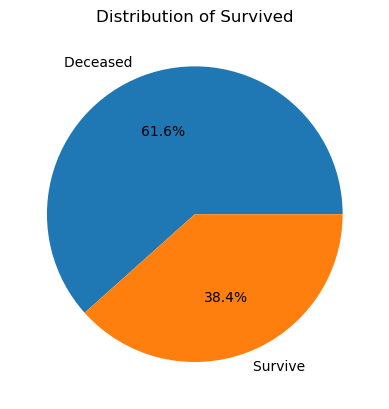

In [355]:
# Create the pie chart
values=df["Survived"].value_counts()
label=["Deceased ","Survive "]
plt.pie(values, labels=label,autopct='%1.1f%%')
# Add a title
plt.title('Distribution of Survived')
# Display the chart
plt.show()

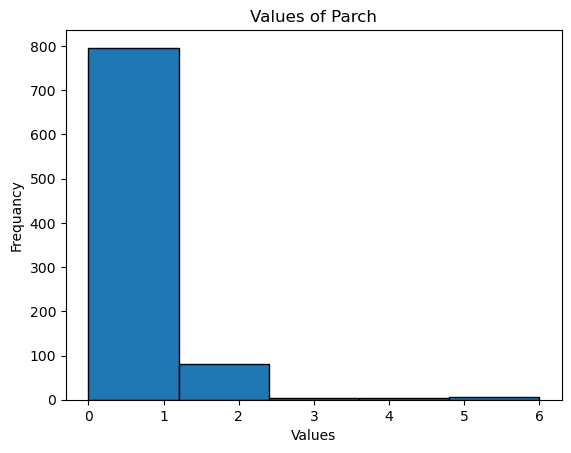

In [356]:
plt.hist(df["Parch"],bins=5, edgecolor='black');
plt.xlabel('Values')
plt.ylabel('Frequancy')
plt.title("Values of Parch")
plt.show();

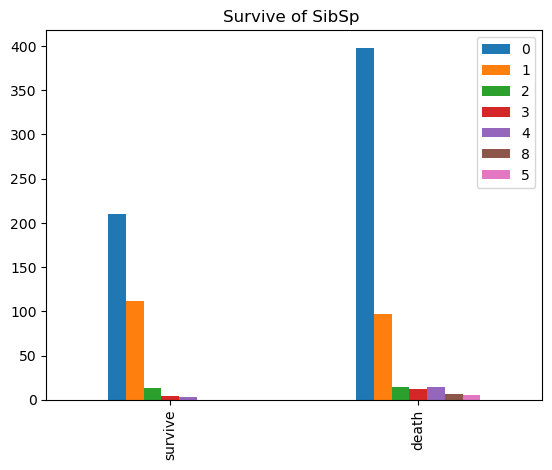

In [357]:
survive=df[df["Survived"]==1]["SibSp"].value_counts()
death=df[df["Survived"]==0]["SibSp"].value_counts()
dx=pd.DataFrame([survive,death],index=["survive","death"])
dx.plot(kind="bar");
plt.title("Survive of SibSp ");


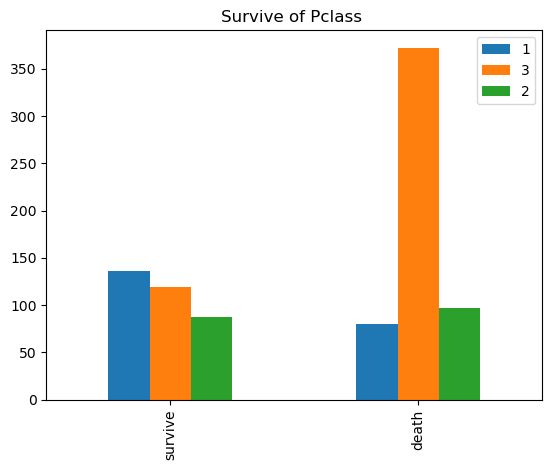

In [358]:
survive=df[df["Survived"]==1]["Pclass"].value_counts()
death=df[df["Survived"]==0]["Pclass"].value_counts()
dx=pd.DataFrame([survive,death],index=["survive","death"])
dx.plot(kind="bar");
plt.title("Survive of Pclass ");


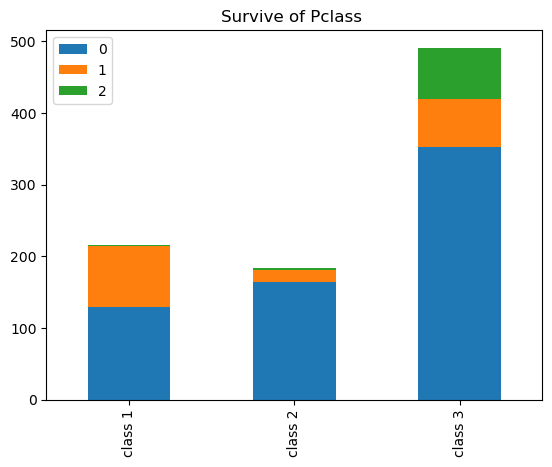

In [359]:
class1=df[df["Pclass"]==1]["Embarked"].value_counts()
class2=df[df["Pclass"]==2]["Embarked"].value_counts()
class3=df[df["Pclass"]==3]["Embarked"].value_counts()
dx=pd.DataFrame([class1,class2,class3],index=["class 1","class 2","class 3"])
dx.plot(kind="bar",stacked=True);
plt.title("Survive of Pclass ");

We Found that Embarked from S in 1st & 2nd & 3rd Class

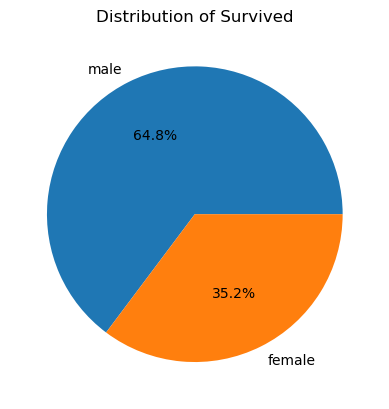

In [360]:
# Create the pie chart
values=df["Sex"].value_counts()
label=["male","female"]
plt.pie(values, labels=label,autopct='%1.1f%%')
# Add a title
plt.title('Distribution of Survived')
# Display the chart
plt.show()

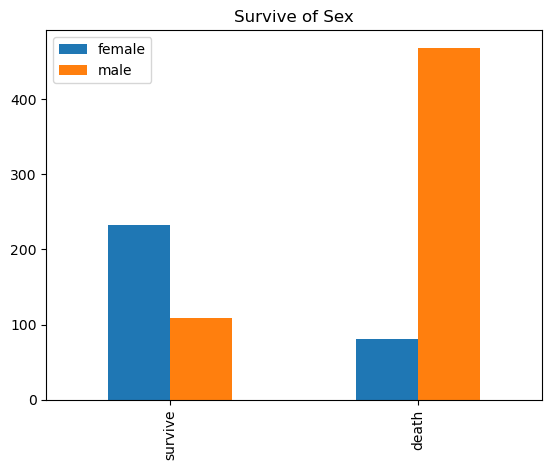

In [361]:
survive = df[df["Survived"]==1]["Sex"].value_counts()
death   = df[df["Survived"]==0]["Sex"].value_counts()
dx      = pd.DataFrame([survive,death],index=["survive","death"])
dx=dx.rename(columns={0:"male",1:"female"})
dx.plot(kind="bar")
plt.legend()
plt.title("Survive of Sex");


<AxesSubplot:>

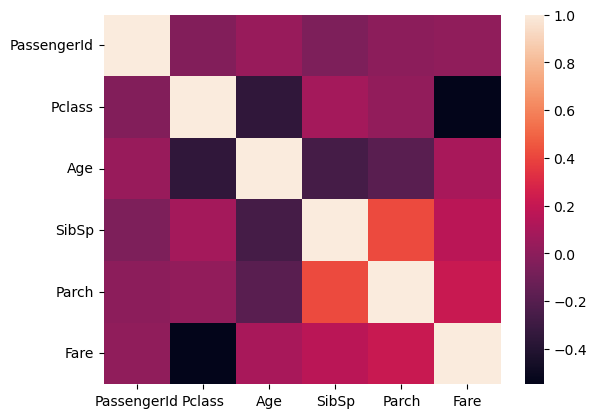

In [362]:
corrleation = df.drop(columns="Survived").corr()
sns.heatmap(corrleation)

# Split Data

In [363]:
df

PassengerId  Survived  Pclass Sex   Age  SibSp  Parch     Fare Embarked
0              1         0       3   0  22.0      1      0   7.2500        0
1              2         1       1   1  38.0      1      0  71.2833        1
2              3         1       3   1  26.0      0      0   7.9250        0
3              4         1       1   1  35.0      1      0  53.1000        0
4              5         0       3   0  35.0      0      0   8.0500        0
..           ...       ...     ...  ..   ...    ...    ...      ...      ...
886          887         0       2   0  27.0      0      0  13.0000        0
887          888         1       1   1  19.0      0      0  30.0000        0
888          889         0       3   1  21.0      1      2  23.4500        0
889          890         1       1   0  26.0      0      0  30.0000        1
890          891         0       3   0  32.0      0      0   7.7500        2

[891 rows x 9 columns]

In [364]:
target="Survived"
y = df[target]
X = df.drop(columns=target)
x_train , x_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("X_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (712, 8)
y_train shape: (712,)
X_test shape: (179, 8)
y_test shape: (179,)


# Baseline

In [365]:
y_train_mean = y_train.mean()
print ("Baseline :",round(y_train_mean,2))

Baseline : 0.38


# Logestic Regression

# Itrate

In [366]:
log_model = LogisticRegression(max_iter=10000)

In [367]:
log_model.fit(x_train,y_train)

LogisticRegression(max_iter=10000)

# 

# Evaluate

In [368]:
accuracy=classification_report(y_test,log_model.predict(x_test))
print(accuracy)

              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



In [369]:
acc_test = accuracy_score(y_test,log_model.predict(x_test))
acc_test = accuracy_score(y_test,log_model.predict(x_test))
acc_train= accuracy_score(y_train,log_model.predict(x_train))
print("Accuracy test:",round(acc_test,2))
print("Accuracy train:",round(acc_train,2))


Accuracy test: 0.8
Accuracy train: 0.8


# KNN Classfier 

In [370]:
knn= KNeighborsClassifier(n_neighbors=13)
knn.fit(x_train,y_train)

KNeighborsClassifier(n_neighbors=13)

In [371]:
accuracy=classification_report(y_test,knn.predict(x_test))
print(accuracy)

              precision    recall  f1-score   support

           0       0.63      0.90      0.75       105
           1       0.66      0.26      0.37        74

    accuracy                           0.64       179
   macro avg       0.64      0.58      0.56       179
weighted avg       0.64      0.64      0.59       179



In [372]:
scoring="accuracy"
score = cross_validate(knn , x_train.drop(columns=["PassengerId"],axis=1),y_train,cv=k_fold, n_jobs=1,scoring=scoring)
print(score['test_score'])

[0.72222222 0.69444444 0.71830986 0.63380282 0.70422535 0.78873239
 0.71830986 0.69014085 0.74647887 0.66197183]


In [373]:
print("Accuracy :",round(np.mean(score['test_score']),2))

Accuracy : 0.71


# Descion Tree

In [374]:
# Create a decision tree classifier
dec_tree=  DecisionTreeClassifier()
# Train the classifier
dec_tree.fit(x_train, y_train)



DecisionTreeClassifier()

In [375]:
accuracy=classification_report(y_test,dec_tree.predict(x_test))
print(accuracy)

              precision    recall  f1-score   support

           0       0.79      0.76      0.78       105
           1       0.68      0.72      0.70        74

    accuracy                           0.74       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.75      0.74      0.74       179



In [376]:
acc_test = accuracy_score(y_test,dec_tree.predict(x_test))
print("Accuracy test:",round(acc_test,2))



Accuracy test: 0.74


In [377]:
scoring="accuracy"
score = cross_validate(dec_tree , x_train.drop(columns=["PassengerId"],axis=1),y_train,cv=k_fold, n_jobs=1,scoring=scoring)
print("Accuracy :",round(np.mean(score['test_score']),2))

Accuracy : 0.78


# Random Forest 

In [378]:
# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()
# Train the classifier
rf_classifier.fit(x_train, y_train)


RandomForestClassifier()

In [379]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, rf_classifier.predict(x_test))
print("Accuracy:", round(accuracy,2))

Accuracy: 0.84


In [380]:
scoring="accuracy"
score = cross_validate(rf_classifier , x_train.drop(columns=["PassengerId"],axis=1),y_train, n_jobs=1,scoring=scoring)
print("Accuracy :",round(np.mean(score['test_score']),1))

Accuracy : 0.8


# Naive Bayes

In [381]:
nav= GaussianNB()
# Train the classifier
nav.fit(x_train, y_train)

GaussianNB()

In [382]:
# Calculate the accuracy
accuracy = accuracy_score(y_test, nav.predict(x_test))
print("Accuracy:", round(accuracy,2))

Accuracy: 0.78


In [383]:
scoring="accuracy"
score = cross_validate(nav , x_train.drop(columns=["PassengerId"],axis=1),y_train, n_jobs=1,scoring=scoring)
print("Accuracy :",round(np.mean(score['test_score']),2))

Accuracy : 0.8


# Communicat

The best model is Random Forest with Accuracy : 82 

In [384]:
pred_test=rf_classifier.predict(test)

data = pd.DataFrame({'PassengerId': test["PassengerId"], 'Survived': pred_test})

In [385]:
data.head()

PassengerId  Survived
0          892         0
1          893         0
2          894         0
3          895         0
4          896         0

In [386]:
data.to_csv(r'D:\projects\gender_submission.csv', index=False)